# STA4020 Final Project Report
### Objective:
- explore the practical applications of asset allocation methodologies in constructing and evaluating investment portfolios. 

### Aims:
- The project aims to help you apply the following key concepts:
    - mean-variance optimization (MVO)
    - equal-weighted portfolios (1/N)
    - the BlackLitterman model for incorporating views. 

</br>
The focus is on analyzing the performance of portfolios both in-sample and out-of-sample, under the given constraints.

---
### Step 1: Data Collection

This reports uses the following 5 stocks in the chosen portfolio. The original data is a 5-year dataset counting backwards from December 2024. The data contains daily open-close prices of the stock.

**Portfolio Construction:**
1) Visa Inc. (V)
2) Mastercard Inc. (MA)
3) American Express Company (AXP)
4) Palantir Technologies Inc (PLTR)
5) NIO Inc. (NIO)

In [1]:
import pandas as pd

# Define the ticker symbols
tickers = ['pltr', 'nio', 'v', 'ma', 'axp', 'tsla']

# Initialize a dictionary to store the data
stock_data = {}

# Loop through each ticker symbol and read the corresponding CSV file
for ticker in tickers:
    file_name = f"{ticker}_quotes.csv"  # Construct the file name
    stock_data[ticker] = pd.read_csv(file_name)  # Read the CSV file and store in dictionary

# Accessing individual stock data
pltr_data = stock_data['pltr']
nio_data = stock_data['nio']
v_data = stock_data['v']
ma_data = stock_data['ma']
axp_data = stock_data['axp']
tsla_data = stock_data['tsla']

**Data preprocessing steps:**
1) Check (and remove) any missing values
2) Truncate the 5 year history into a 2 year and 3 months history
    - `3 months`: Sept 2024 - Nov 2024
    - `2 years`: Aug 2022 - Aug 2024
3) Convert String values to Float (due to the `$` character)
4) Add `Returns` and `% Returns` column for the processed data
5) Partition the datasets into In-Sample and Out-Sample
    - `in_sample`: 2 years of previous data
    - `out_sample`: 3 months of latest data

**Formulae used for computing `Returns` and `% Returns`:**
1. **Daily Return (in dollars)**:
   $$\text{Daily Return} = (P_{\text{closing}} - P_{\text{opening}}) $$
   where:
   - $ P_{\text{closing}} $ = closing price
   - $ P_{\text{opening}} $ = opening price

2. **Percentage Return**:
   $$\text{Percentage Return} = \left( \frac{P_{\text{closing}} - P_{\text{opening}}}{P_{\text{opening}}} \right) \times 100$$


*note that in our dataframes, the `% Returns` columns are kept as a value between 0 & 1

At this juncture, we will also define our start and end dates for both `in` and `out` samples as variables

In [2]:
dates = {
    "in_sample" : {
        "start": '2022-08-01',
        "end": '2024-08-31',
        "start_text": 'Augest 2022',
        "end_text": 'August 2024'
    },
    "out_sample" : {
        "start" : '2024-09-01',
        "end" : '2024-11-30',
        "start_text" : 'September 2024',
        "end_text" : 'November 2024'
    }
}

Proceed with data preprocessing

In [3]:
# Check for null values in each stock data
null_checks = {
    "Palantir": pltr_data.isnull().sum().sum(),
    "NIO": nio_data.isnull().sum().sum(),
    "Visa": v_data.isnull().sum().sum(),
    "Mastercard": ma_data.isnull().sum().sum(),
    "American Express": axp_data.isnull().sum().sum(),
    "Tesla": tsla_data.isnull().sum().sum()
}

all_datasets_valid = True

for company, null_count in null_checks.items():
    if null_count > 0:
        print(f"{company} DataFrame has {null_count} null values.")
        all_datasets_valid = False

if all_datasets_valid:
    print("All datasets do not have null values.")

All datasets do not have null values.


Here we define some preprocessing functions

In [4]:
# Define function to convert the 'Date' column to datetime format
def convert_to_datetime(data):
    data['Date'] = pd.to_datetime(data['Date'])
    return data

# Define function to keep all rows within a specified date range and reindex the dataframe
def filter_by_date(data, start_date, end_date):
    data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    data = data.reset_index(drop=True)
    return data

# Define function to remove '$' character from the selected columns and convert the remaining values to float
def clean_currency(x):
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '')
    return x

# Define the columns to clean
columns_to_clean = ['Close/Last', 'Open', 'High', 'Low']

# Define function to calculate Returns and % Returns
def calculate_returns(data):
    data['Returns'] = data['Open'].astype(float) - data['Close/Last'].astype(float)
    data['% Returns'] = data['Returns'] / data['Open'].astype(float)
    return data

Then we apply these functions onto our datasets

In [5]:
# Apply the functions to each stock data and update the dictionary
for ticker in tickers:
    stock_data[ticker] = convert_to_datetime(stock_data[ticker])
    stock_data[ticker] = filter_by_date(stock_data[ticker], dates["in_sample"]["start"], dates["out_sample"]["end"])
    stock_data[ticker][columns_to_clean] = stock_data[ticker][columns_to_clean].map(clean_currency)
    stock_data[ticker] = calculate_returns(stock_data[ticker])

# Accessing individual stock data
pltr_data = stock_data['pltr']
nio_data = stock_data['nio']
v_data = stock_data['v']
ma_data = stock_data['ma']
axp_data = stock_data['axp']
tsla_data = stock_data['tsla']

Now we partition our datasets into `in_sample` and `out_sample`

In [6]:
# Create new dictionary to store each partition of the original data
stock_data_in_sample = {}
stock_data_out_sample = {}

# Loop through each ticker symbol and split the data into in-sample and out-of-sample
for ticker in tickers:
    stock_data_in_sample[ticker] = stock_data[ticker].loc[stock_data[ticker]['Date'] <= dates["in_sample"]["end"]].reset_index(drop=True)
    stock_data_out_sample[ticker] = stock_data[ticker].loc[stock_data[ticker]['Date'] > dates["in_sample"]["end"]].reset_index(drop=True)

# Accessing individual stock data
pltr_data_in_sample = stock_data_in_sample['pltr']
nio_data_in_sample = stock_data_in_sample['nio']
v_data_in_sample = stock_data_in_sample['v']
ma_data_in_sample = stock_data_in_sample['ma']
axp_data_in_sample = stock_data_in_sample['axp']
tsla_data_in_sample = stock_data_in_sample['tsla']

pltr_data_out_sample = stock_data_out_sample['pltr']
nio_data_out_sample = stock_data_out_sample['nio']
v_data_out_sample = stock_data_out_sample['v']
ma_data_out_sample = stock_data_out_sample['ma']
axp_data_out_sample = stock_data_out_sample['axp']
tsla_data_out_sample = stock_data_out_sample['tsla']


### Step 2: MVE Portfolio Construction
In this section, we construct the mean-variance efficient (MVE) portfolio using the `in_sample` data

1. Use `in_sample` data to calculate the average returns (%) and covariance matrix of the selected assets in our portfolio

In [7]:
import numpy as np 

# put all in-sample % return data into the same dataframe
returns_pct_in_sample = pd.DataFrame({
    'PLTR': pltr_data_in_sample['% Returns'],
    'NIO': nio_data_in_sample['% Returns'],
    'V': v_data_in_sample['% Returns'],
    'MA': ma_data_in_sample['% Returns'],
    'AXP': axp_data_in_sample['% Returns'],
    'TSLA': tsla_data_in_sample['% Returns']
})

# Calculate expected returns and covariance matrix
expected_returns = returns_pct_in_sample.mean()
cov_matrix = returns_pct_in_sample.cov()

# Create a DataFrame to display the expected returns and covariance matrix
output_table = pd.DataFrame(cov_matrix)
output_table.loc['Expected Returns'] = expected_returns

# Reorder the rows to have 'Expected Returns' at the top
output_table = output_table.reindex(['Expected Returns'] + list(cov_matrix.index))

output_table

,PLTR,NIO,V,MA,AXP,TSLA
Expected Returns,-0.001605,0.001812,-0.000646,-0.000572,-0.000853,-0.000060
PLTR,0.001057,0.000526,0.000088,0.000111,0.000147,0.000442
NIO,0.000526,0.001356,0.000095,0.000110,0.000150,0.000477
V,0.000088,0.000095,0.000104,0.000088,0.000071,0.000085
MA,0.000111,0.000110,0.000088,0.000108,0.000076,0.000085
AXP,0.000147,0.000150,0.000071,0.000076,0.000179,0.000144
TSLA,0.000442,0.000477,0.000085,0.000085,0.000144,0.000821


2. Optimize portfolio weights by minimizing the portfolio variance while maximizing the Sharpe Ratio under the 'no-short-selling' constraint i.e.  $  \omega_i \geq 0$

In [8]:
from scipy.optimize import minimize

n_assets = len(tickers)

# Define minimizing function
def portfolio_variance(weights):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Set constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(n_assets))

# Set initial weights (equal distribution, 1/n)
initial_weights = np.ones(n_assets) / n_assets

# Optimize
optimal_solution = minimize(portfolio_variance, initial_weights,
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = optimal_solution.x

print("Optimal Weights:", optimal_weights)

Optimal Weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


3. Make comparisons between MVE portfolio and the equal weighted portfolio

In [9]:
# Performance metrics for MVE portfolio
mve_return = np.dot(optimal_weights, expected_returns)
mve_std_dev = np.sqrt(portfolio_variance(optimal_weights))
mve_sharpe_ratio = mve_return / mve_std_dev  # Risk-free rate is 0

# Performance metrics for Equal-Weighted Portfolio
equal_weights = np.array([1/n_assets] * n_assets)
equal_return = np.dot(equal_weights, expected_returns)
equal_std_dev = np.sqrt(portfolio_variance(equal_weights))
equal_sharpe_ratio = equal_return / equal_std_dev

# Display the comparisons using a dataframe
performance_metrics = pd.DataFrame({
    'MVE Portfolio': [mve_return, mve_std_dev, mve_sharpe_ratio],
    'Equal-Weighted Portfolio': [equal_return, equal_std_dev, equal_sharpe_ratio]
}, index=['Expected Return', 'Standard Deviation', 'Sharpe Ratio'])

performance_metrics

,MVE Portfolio,Equal-Weighted Portfolio
Expected Return,-0.000321,-0.000321
Standard Deviation,0.015826,0.015826
Sharpe Ratio,-0.020263,-0.020263


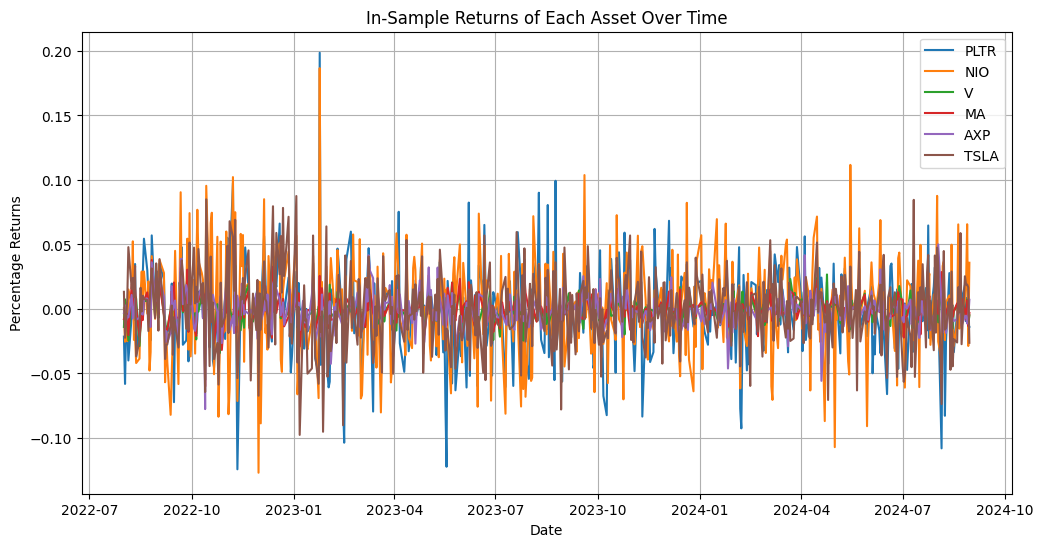

In [10]:
import matplotlib.pyplot as plt

# Plotting the returns of each asset over time
plt.figure(figsize=(12,6))

for ticker in tickers:
    plt.plot(stock_data_in_sample[ticker]['Date'], stock_data_in_sample[ticker]['% Returns'], label=ticker.upper())

plt.title('In-Sample Returns of Each Asset Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage Returns')
plt.legend()
plt.grid(True)
plt.show()

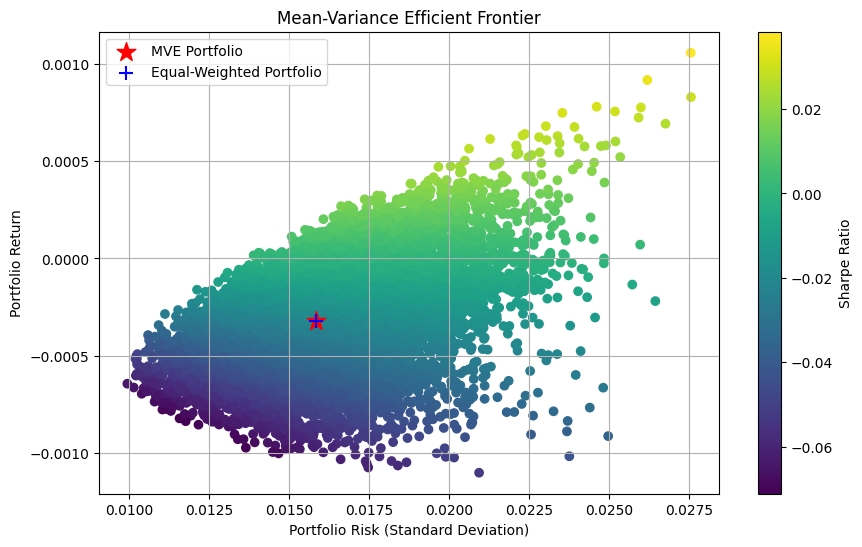

In [11]:
import matplotlib.pyplot as plt

# Generate portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)  # Normalize weights
    weights_record.append(weights)

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = portfolio_std_dev
    results[1, i] = portfolio_return
    results[2, i] = (portfolio_return - 0) / portfolio_std_dev  # Sharpe Ratio

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results.T, columns=['std_dev', 'returns', 'sharpe_ratio'])

# Plotting the MVE Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results_df['std_dev'], results_df['returns'], c=results_df['sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(mve_std_dev, mve_return, color='red', marker='*', s=200, label='MVE Portfolio')
plt.scatter(equal_std_dev, equal_return, color='blue', marker='+', s=100, label='Equal-Weighted Portfolio')
plt.title('Mean-Variance Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid()
plt.show()


### Step 3: Black Litterman Model
In this section we implement the Black-Litterman (BL) Model, this will incorporate some qualitative research of our portfolio assets.

1. We compute the prior expected excess returns
    - Use long-window average, can be achieved using mean of returns of assets
    - Assign value of $ \tau $ = `0.025` for covariance matrix calculation
    - Assign value of $ \delta $ = `2.5` for Risk Aversion Coefficient

In [ ]:
# Calculate the prior expected excess returns
def calculate_prior(assets):
    returns = np.array([stock_data_in_sample[symbol]['% Returns'].mean() for symbol in assets])
    return returns

# Covariance matrix calculation
def calculate_covariance(assets):
    returns = np.array([stock_data_in_sample[symbol]['% Returns'] for symbol in assets])
    return np.cov(returns)

# Parameters
tau = 0.025
d = 2.5  # Risk aversion coefficient
market_weights = np.array([1/len(ticker)] * len(ticker))  # Equal weights

2. Now we define our views (relative or absolute) based on news articles and analyst reports that are readily available on the internet.

**View 1:** </br>
Semi-negative view; Visa faces headwinds in the short run, with a daily excess return of -2%. Uncertainty 2%. </br>
**Explanation:** </br>
Visa has favorable earnings estimates, having beaten earnings in the past four quarters of 2024. However, the company is currently facing significant challenges, including recent legal lawsuits related to antitrust concerns and shifting political agendas, such as the Credit Card Competition Act 2023. These factors are likely to slow Visa's growth, leading to a short-term decline in returns *(Dey, 2024)*.

**View 2:** </br> 
Relative view; Nio is expected to outperform Tesla by 1%. Uncertainty 0.5%. </br>
**Explanation:** </br>
Nio's higher-spec, lower-priced models, along with its general mass-market offerings, have significantly boosted EV sales across China. In September 2024, Nio achieved its second-highest monthly deliveries (21,181), with sales rising 11.6% year-over-year and 7.8% quarter-over-quarter. The competitive starting price of Nio's Onvo L60 (USD 21,000) compared to Tesla's Model Y (USD 35,000) in China presents a strong challenge to Tesla. Additionally, other Chinese EV manufacturers are also advancing their sales, further challenging Tesla's position as the bestselling EV in China. Nio's integration of Nvidia's cutting-edge AI chip in the L60 provides it with a unique selling point over competitors *(NARAYANAN & Daily, 2024)*.

**View 3:** </br>
Palantir's expected daily excess return is 5%, with an uncertainty of 3%. </br>
**Explanation:** </br>
Palantir's stock has soared over 300% this year due to the rising demand for Artificial Intelligence (AI). As a major player in the AI and defense markets, the anticipated increase in government spending has significantly contributed to Palantir's growth, bringing its market capitalization to 161 billion USD *(Glover, 2024)*. Palantir is also set to enter the Nasdaq 100 on December 23, 2024. However, due to production lags in AI applications, much of Palantir's value is expected to be realized in the coming years *(PIMENTEL & Daily, 2024)*. </br>

**View 4:** </br>
Visa is forecasted to outperform American Express by 2% daily, with an uncertainty of 1%. </br>
**Explanation:** </br>
American Express (AXP) operates as a broader business compared to Visa's credit card network, allowing Visa to maintain lower costs. Additionally, not being a bank reduces Visa's exposure to credit risks, contributing to a larger profit margin for Visa *(Saibil, 2024)*. </br>

**View 5:** </br>
Mastercard is forecasted to outperform Visa by 1% daily, with an uncertainty of 4%. </br>
**Explanation:** </br>
Although both companies have beaten earnings estimates over the past four quarters, Visa may face more significant headwinds than Mastercard *(Dey, 2024b)*. Antitrust lawsuits against Visa are currently under investigation, while Mastercard has reached an agreement regarding its collective lawsuit on card fees *(Murphy, 2024)*. This situation may lead to a positive shift in investors' outlook on Mastercard. </br>

In [ ]:
# Step 2: Define views (placeholder values)
P = np.array([[1, -1, 0, 0, 0, 0],  # View 1
              [0, 0, 0, 1, -1, 0]])  # View 2
q = np.array([0.02, 0.01])  # Expected excess returns for views
Omega = np.diag([0.0001, 0.0001])  # Uncertainty of the views

### Step 4: Out-of-sample Portfolio Evaluation